# Kmeans
written by Eric Bridgeford and Theodor Marinov

In this notebook, we will investigate the K-means clustering implementation provided for our course project.

## Algorithm Basics

The algorithm used here is standard K-means with K-means++ inialization. At a high level, the algorithm for K-means is as follows:

### K-means

1. Initialize centers
2. while not converged:
    + Find the closest center for each data point.
    + for each center, average all of the points that are assigned and use this as the new center
    + check for convergence condition
3. end

Here, we define convergence as either the algorithm reaching the maximum number of iterations (defaulted to 100) or the sum from each point to its closest center not changing on a given iteration. To initialize the centers, we perform the following algorithm:

### K-means++ Initialization

1. choose one data point randomly.
2. while fewer than K centers chosen:
    + compute the squared distance from each point to its respective center.
    + normalize the squared distances to a pmf.
    + randomly choose a new center using the squared distance pmf.
3. end

Essentially, what we are doing is just choosing center points randomly, but evenly distributed throughout our data. K-means can perform poorly when the initial centers are too close or overlapping. This is not the focus of our paper, so we will try to keep the details brief. For more details, see the wikipedia [page](https://en.wikipedia.org/wiki/K-means%2B%2B).

# Simulations

## Basic Simulation - Perfectly Separable

For our first basic simulation, we will check how well our algorithm performs on a perfectly separable 2D dataset.

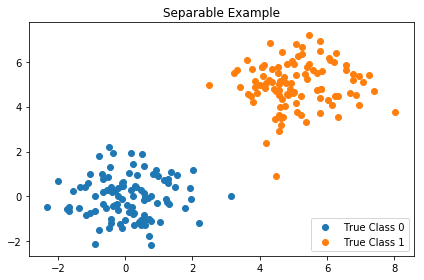

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Separable Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

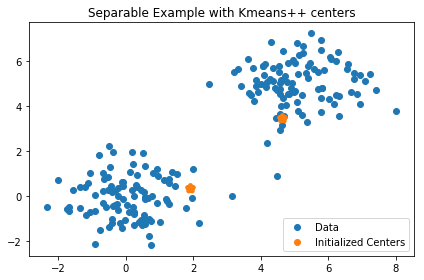

In [30]:
km = Kmeans(K=2)
km.initialize(data)

# visualize the centers
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.set_title('Separable Example')
ax.legend((scat1, scat2, scat3),
           ('Data', 'Initialized Centers'),
           loc='lower right')
ax.set_title('Separable Example with Kmeans++ centers')
fig.tight_layout()
fig.show()

As we can see, the initialized centers chosen by K-means++ choose data points randomly that are far apart, which is exactly what we want. Next, we run the algorithm and visualize the new centers, along with the classifications:

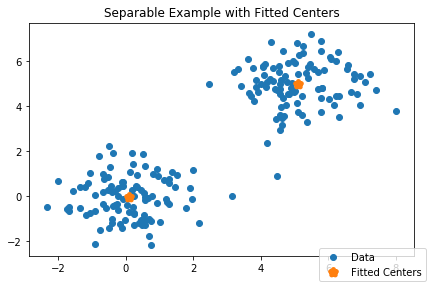

In [31]:
km.fit()
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
fig.legend((scat1, scat3),
           ('Data', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Separable Example with Fitted Centers')
fig.tight_layout()
fig.show()

As we can see, it looks like our fitted centers will give us a good split of the data. Let's see how the algorithm does classifying our points:

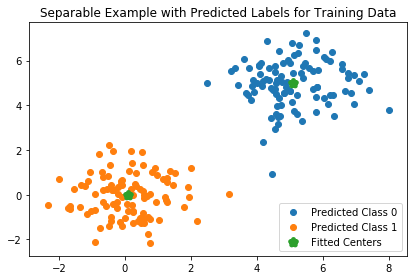

In [32]:
pred_labels = km.get_assignments(data)

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, pred_labels == 0], data[1, pred_labels == 0])
scat2 = ax.scatter(data[0, pred_labels == 1], data[1, pred_labels == 1])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.legend((scat1, scat2, scat3),
           ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Separable Example with Predicted Labels for Training Data')
fig.tight_layout()
fig.show()

Next, we visualize to make sure our model is actually converging. Here, we want to see that the sum of distances is always decreasing on each iteration:

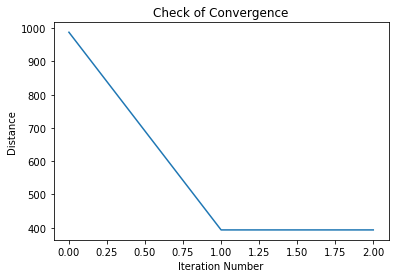

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(km.niter), km.dist[0:km.niter])
ax.set_ylabel('Distance')
ax.set_xlabel('Iteration Number')
ax.set_title('Check of Convergence')
fig.show()

Note that our class labels are flipped, which is fine since our algorithm arbitrarily assigns labels anyway (this is because the center numbers are completely arbitrary). We measure classification accuracy using the purity statistic:

It is computed as follows:
\begin{align*}
    P(M, D) = \frac{1}{N}\sum_{m \in M} \max_{d \in D} \left\{\left|m \cap d\right|\right\}
\end{align*}

where $D$ is a set of true classes and $M$ is our set of possible assigned clusters. This statistic basically measures the homogeneity of a given cluster. For more details, see [cluster evaluation](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation). We do this by first creating a confusion matrix, and then using the confusion matrix to obtain the purity information. 

purity = 1.0


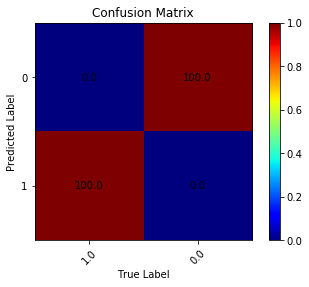

In [34]:
from clustering.utils import purity

(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

# Basic Simulation 2: Less Separable

Here, we will look at the performance on a un-separable example, but one in which we should still get a decent score, as there will be enough of a separation for the algorithm to still separate the data decently well.

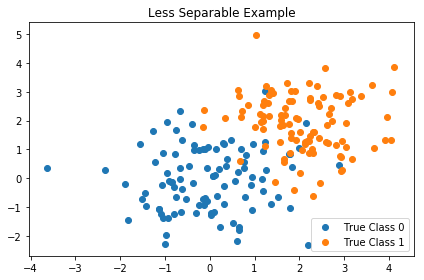

In [35]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 2*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Less Separable Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

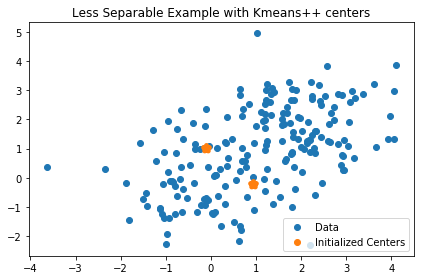

In [36]:
km = Kmeans(K=2)
km.initialize(data)

# visualize the centers
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.set_title('Separable Example')
ax.legend((scat1, scat2, scat3),
           ('Data', 'Initialized Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Kmeans++ centers')
fig.tight_layout()
fig.show()

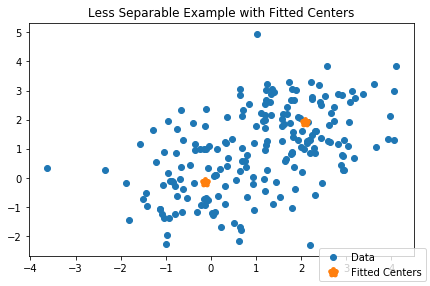

In [37]:
km.fit()
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
fig.legend((scat1, scat3),
           ('Data', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Fitted Centers')
fig.tight_layout()
fig.show()

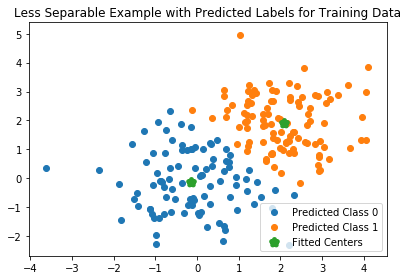

In [38]:
pred_labels = km.get_assignments(data)

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, pred_labels == 0], data[1, pred_labels == 0])
scat2 = ax.scatter(data[0, pred_labels == 1], data[1, pred_labels == 1])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.legend((scat1, scat2, scat3),
           ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Predicted Labels for Training Data')
fig.tight_layout()
fig.show()

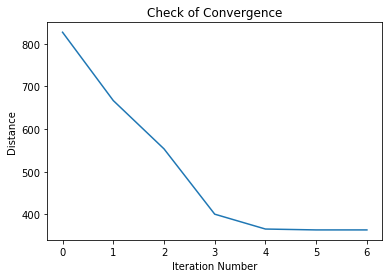

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(km.niter), km.dist[0:km.niter])
ax.set_ylabel('Distance')
ax.set_xlabel('Iteration Number')
ax.set_title('Check of Convergence')
fig.show()

purity = 0.925


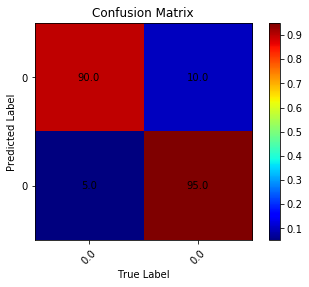

In [40]:
from clustering.utils import purity

(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

As we can see, our classification is understandably not perfect (our data is not linearly separable, so we know that since Kmeans places the data into Voronoi cells, we could never get perfect classification) we still get a high purity score.

# Basic Simulation 3: Completely Inseparable Example

Here, we will see how the algorithm works on a dataset with very poor separability. We should obtain a very poor score, as the lack of separability means that our predictions will be bad.

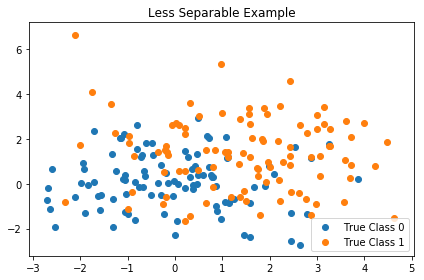

In [43]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 2*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 3*np.identity(d)
mean2 = 1.5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Completely Unseparable Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

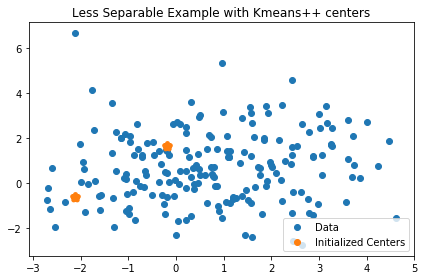

In [45]:
km = Kmeans(K=2)
km.initialize(data)

# visualize the centers
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.set_title('Separable Example')
ax.legend((scat1, scat2, scat3),
           ('Data', 'Initialized Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Kmeans++ centers')
fig.tight_layout()
fig.show()

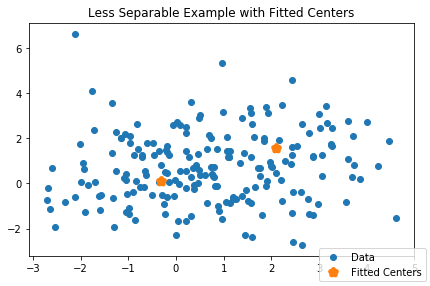

In [46]:
km.fit()
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
fig.legend((scat1, scat3),
           ('Data', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Fitted Centers')
fig.tight_layout()
fig.show()

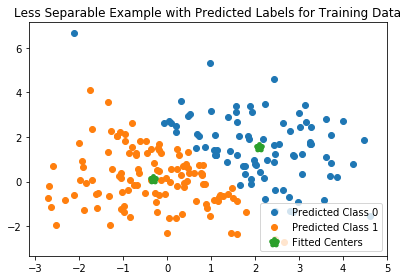

In [47]:
pred_labels = km.get_assignments(data)

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, pred_labels == 0], data[1, pred_labels == 0])
scat2 = ax.scatter(data[0, pred_labels == 1], data[1, pred_labels == 1])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.legend((scat1, scat2, scat3),
           ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Predicted Labels for Training Data')
fig.tight_layout()
fig.show()

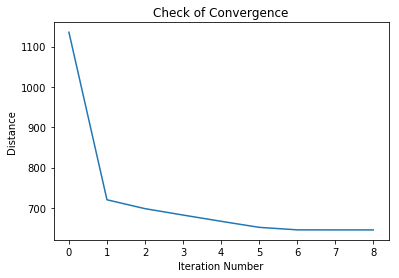

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(km.niter), km.dist[0:km.niter])
ax.set_ylabel('Distance')
ax.set_xlabel('Iteration Number')
ax.set_title('Check of Convergence')
fig.show()

purity = 0.765


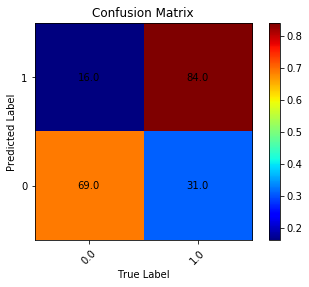

In [49]:
from clustering.utils import purity

(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

As we would expect, our purity score indicates that we are still able to yield some information with our trained classifier, but the score is still far from adequate to characterize the given data. 

# Complex Simulation 1: K>2 Classes

Here, we will illustrate the performance of K-means on a $K>2$ dataset. We will arbitrarily try $K=5$.

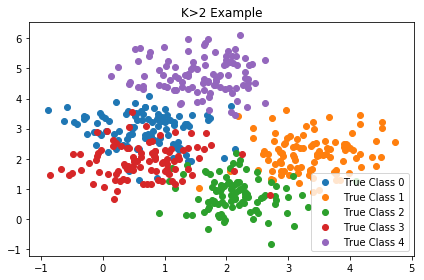

In [93]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
K=5
xmean = np.random.uniform(low=0, high=5, size=K).tolist()
ymean = np.random.uniform(low=0, high=5, size=K).tolist()
variance = np.array([0.3, 0.35, 0.25, .32, 0.3]).tolist()

data_per_class = []
for i, (x, y, v) in enumerate(zip(xmean, ymean, variance)):
    data_per_class.append(np.random.multivariate_normal(mean = np.array([x, y]),
                                                        cov = v*np.identity(d),
                                                        size=n).transpose())

for i, d in enumerate(data_per_class):
    if i == 0:
        data = data_per_class[i]
        true_labels = i*np.ones((n,))
    else:
        data = np.hstack((data, data_per_class[i]))
        true_labels = np.concatenate((true_labels, i*np.ones((n,))))

idx = np.array(range(0, len(true_labels)))
np.random.shuffle(idx)
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
label = []
scat = []
for i in range(0, K):
    scat.append(ax.scatter(data[0, true_labels == i],
                           data[1, true_labels == i]))
    label.append('True Class {}'.format(i))

ax.set_title('K>2 Example')
ax.legend(tuple(scat), tuple(label), loc='lower right')
fig.tight_layout()
fig.show()

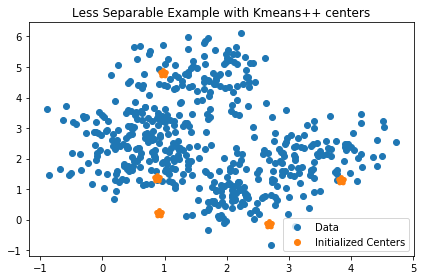

In [94]:
km = Kmeans(K=5)
km.initialize(data)

# visualize the centers
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.set_title('K>2 Example')
ax.legend((scat1, scat2, scat3),
           ('Data', 'Initialized Centers'),
           loc='lower right')
ax.set_title('Less Separable Example with Kmeans++ centers')
fig.tight_layout()
fig.show()

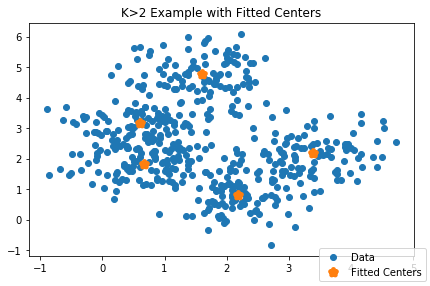

In [95]:
km.fit()
Cent = np.vstack(km.get_centers()).transpose()

fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, :], data[1, :])
scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
fig.legend((scat1, scat3),
           ('Data', 'Fitted Centers'),
           loc='lower right')
ax.set_title('K>2 Example with Fitted Centers')
fig.tight_layout()
fig.show()

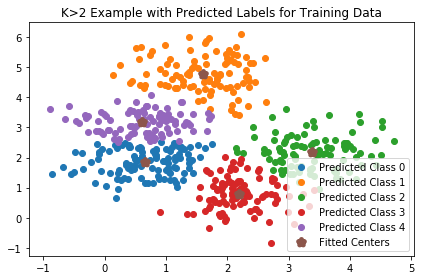

In [96]:
pred_labels = km.get_assignments(data)

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
label = []
scat = []
for i in range(0, K):
    scat.append(ax.scatter(data[0, pred_labels == i],
                           data[1, pred_labels == i]))
    label.append('Predicted Class {}'.format(i))
scat_cents =ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
ax.set_title('K>2 Example with Predicted Labels for Training Data')
ax.legend(tuple(scat + [scat_cents]), tuple(label + ['Fitted Centers']), loc='lower right')
fig.tight_layout()
fig.show()

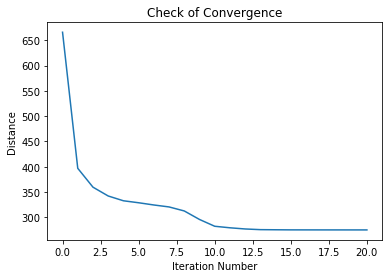

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(km.niter), km.dist[0:km.niter])
ax.set_ylabel('Distance')
ax.set_xlabel('Iteration Number')
ax.set_title('Check of Convergence')
fig.show()

purity = 0.888


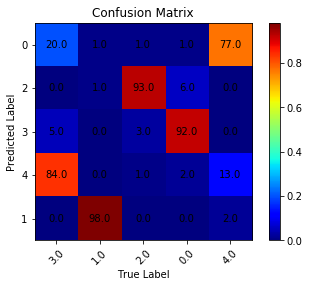

In [98]:
from clustering.utils import purity

(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

We get a good purity score for our $K>2$ case, and we can see that each true class is associated strongly with one predicted class.